In [19]:
import os
import PIL
device='cuda'
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from torch.nn import Module
from torch.optim import AdamW
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

In [20]:
alphabet=[symb for symb in 'ABEKMHOPCTYX0123456789']
let2int={i:let for let,i in enumerate(alphabet)}
int2let={let:i for let,i in enumerate(alphabet)}

In [21]:
#удаление ненужного
path='//home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/train/img'
for file in os.listdir(path):
    if 'Unknown' in file or file.count('_')>1:
        os.remove(os.path.join(path,file))
path='//home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/train/ann'
for file in os.listdir(path):
    if 'Unknown' in file or file.count('_')>1:
        os.remove(os.path.join(path,file))
    if file.count('_')>1:
        os.remove(os.path.join(path,file))
    

In [22]:
class NumberDataset(Dataset):
    def __init__(self,path,number_len):
        super(NumberDataset,self).__init__()
        self.number_len=number_len
        img_path=os.path.join(path,'img')
        label_path=os.path.join(path,'ann')

        #номера
        self.image_numbers=[img[:-4] for img in os.listdir(img_path)]
        self.label_numbers=[label[:-5] for label in os.listdir(label_path)]
        
        #изображения и лейблы 
        self.images=[os.path.join(img_path,img) for img in os.listdir(img_path) if img[:-4] in self.label_numbers]
        self.labels=[os.path.join(label_path,label) for label in os.listdir(label_path) if label[:-5] in self.image_numbers]
        
        self.images.sort(reverse=True)
        self.labels.sort(reverse=True)

        self.trans=transforms.Compose([
            transforms.Resize((64,128)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        idx_img=Image.open(self.images[idx]).convert('RGB')
        idx_label=self.labels[idx]
        
        with open(idx_label,'r') as file_option:
            jf=json.load(file_option)
            #return jf['name'][0:self.number_len]
            tensor_label=torch.tensor([let2int[let] for let in jf['description'][0:self.number_len] if let!='_'])
        tensor_img=self.trans(idx_img)
        return {
            'img':tensor_img,
            'label':tensor_label,
            'label_len':len(tensor_label)
        }

In [23]:
# for i in range(10000):
#     a=[let for let in number_data[i] if let!='_']
#     print(a)

In [24]:
def collate_fn(batch):
    imgs = torch.stack([x['img'] for x in batch])
    labels=[x['label'] for x in batch]
    label_lens=torch.tensor([x['label_len'] for x in batch])
    label = torch.cat(labels)
    return imgs,label,label_lens

In [25]:
number_data=NumberDataset('//home/artemybombastic/MyGit/VehicleNumberData/VNR_Data/train',9)
number_dataloader=DataLoader(number_data,batch_size=16,shuffle=False,drop_last=True,collate_fn=collate_fn)

In [26]:
for i in number_data[5]['label']:
    print(int2let[i.item()])

Y
9
9
9
P
X
1
9
7


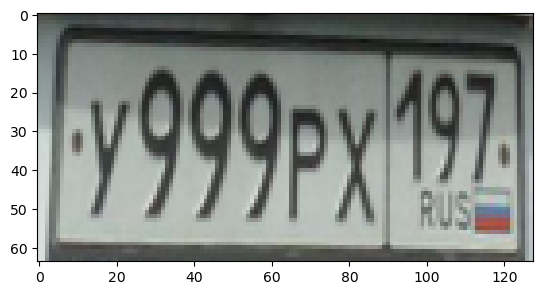

In [27]:
plt.imshow(number_data[5]['img'].permute(1,2,0).detach())

In [28]:
class ResnetBlock(Module):
    def __init__(self,input_size,output_size,stride=1,downsample=None):#downsample нужно в случае понижения размерности блока):
        super().__init__()
        self.act=nn.ReLU(inplace=True)
        self.conv0=nn.Conv2d(input_size,output_size,kernel_size=3,stride=stride,padding=1)
        self.norm0=nn.BatchNorm2d(output_size)

        self.conv1=nn.Conv2d(output_size,output_size,kernel_size=3,stride=1,padding=1)
        self.norm1=nn.BatchNorm2d(output_size)

        self.downsample=downsample
    def forward(self,x):
        out=self.conv0(x)
        out=self.norm0(out)
        out=self.act(out)
        out=self.conv1(out)
        out=self.norm1(out)
        if self.downsample:
            x=self.downsample(x)
        out+=x
        out=self.act(out)

        return out
        
        

In [29]:
def make_layers(block,cnt,input_size,output_size,stride=1,downsample=False):
    blocks=[]

    if downsample or input_size!=output_size or stride!=1:
        downsample=nn.Sequential(
            nn.Conv2d(input_size,output_size,1,stride,bias=False),
            nn.BatchNorm2d(output_size)
        )

    blocks.append(block(input_size,output_size,stride,downsample))    
    for i in range(1,cnt):
        blocks.append(block(output_size,output_size))

    return nn.Sequential(*blocks)
    

In [30]:
class Resnet34(Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()

        self.initial_lay=nn.Sequential(
            nn.Conv2d(input_size,hidden_size,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

        self.lay0=make_layers(block=ResnetBlock,cnt=3,input_size=hidden_size,output_size=hidden_size,downsample=False)
        self.lay1=make_layers(block=ResnetBlock,cnt=4,input_size=hidden_size,output_size=hidden_size*2,stride=(2,1),downsample=True)
        self.lay2=make_layers(block=ResnetBlock,cnt=6,input_size=hidden_size*2,output_size=hidden_size*4,stride=(2,1),downsample=True)
        self.lay3=make_layers(block=ResnetBlock,cnt=3,input_size=hidden_size*4,output_size=hidden_size*8,stride=(2,1),downsample=True)

        self.avg_pool=nn.AdaptiveAvgPool2d((1,None))
        
    def forward(self,x):
        #print(x.shape)
        out=self.initial_lay(x)
        #print(out.shape)
        #print('СЛОИ:')
        out=self.lay0(out)
        #print(out.shape)
        out=self.lay1(out)
        #print(out.shape)
        out=self.lay2(out)
        #print(out.shape)
        out=self.lay3(out)
        #print(out.shape)

        final_out=self.avg_pool(out)
        #print(final_out.shape)
        return final_out

In [31]:
class CRNN(Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()

        self.cnn=Resnet34(3,64)
        self.rnn=nn.LSTM(hidden_size*8,hidden_size*4,num_layers=1,bidirectional=True)
        self.final_lay=nn.Sequential(    
            nn.Linear(512,len(alphabet)+1)
        )
                
    def forward(self,x):
        out=self.cnn(x)
        #print(out.shape)

        out=out.squeeze(2).permute(2,0,1)
        #out=self.flat(out)
        #print(out.shape)
        out,_=self.rnn(out)

        out=self.final_lay(out)

        #финальная размерность длина_строки*batch*размер_алфвавита

        return out

In [38]:
loss_fn=nn.CTCLoss()
model=CRNN(input_size=3,hidden_size=64).to(device)
optimizer=AdamW(model.parameters())

In [ ]:
for i in range(100):
    losses=[]
    for batch in (pbar:=tqdm(number_dataloader)):
        optimizer.zero_grad()
        img,label,label_len=batch
        pred=model(img.to(device))

        T = pred.size(0)
        N = pred.size(1)
        input_len = torch.full(size=(N,), fill_value=T, dtype=torch.int32)

        
        pred=pred.log_softmax(dim=2)
        loss=loss_fn(pred,label,input_len,label_len)
        loss.backward()
        loss_item=loss.item()
        losses.append(loss_item)
        optimizer.step()
        pbar.set_description(f"loss: {loss_item}")
        
        #pbar.set_descriptiont()
    print(f'mean_loss: {sum(losses)/len(losses)}')
        
    

1.4139585494995117: 100%|█████████| 2776/2776 [02:38<00:00, 17.47it/s]


mean_loss:1.6333757548858694


1.27582585811615: 100%|███████████| 2776/2776 [02:39<00:00, 17.37it/s]


mean_loss:0.9293645631725919


1.087658166885376: 100%|██████████| 2776/2776 [02:21<00:00, 19.57it/s]


mean_loss:0.7402817064128623


1.132554531097412: 100%|██████████| 2776/2776 [02:06<00:00, 21.99it/s]


mean_loss:0.7469247238769569


0.54973965883255:  83%|█████████▏ | 2304/2776 [01:44<00:21, 21.73it/s]

In [ ]:
def translate(message):
    message=[int2let[i.item()] for i in message]
    return ''.join(message)

In [ ]:
translate(pred.argmax(dim=2)[-1])

In [ ]:
[int2let[i.item()] for i in pred.argmax(dim=2)[2]]